# Data Loading Examples
## Import packages
- Calibration code is being developed as a python package that can import any necessary class or function.
    - Called "hallprobecalib"
    - Once installed, can be used in any instance of python on that computer
    - may add to PyPI (Python Package Index) for installation via 'pip'

### Install
<https://github.com/ckampa13/hallprobecalib>
- clone repository
- `hallprobecalib/hallprobecalib/__init__.py`, line 3: set proper "hpc_ext_path" (hall probe calibration external data path)
e.g. I use ~/Coding/hallprobecalib_extras/
    - split data directory into 'datafiles' (raw, pickled) and 'plots'
- in terminal, navigate to `hallprobecalib` (base repository directory) and install:
    ### **`pip install -e .`**

**Disclaimer:** I have not gone through the necessary steps to make sure package dependancies are installed when installing hallprobecalib. First runtime errors will likely be missing packages (install with pip, conda, etc). Will work this out eventually.

In [1]:
from sys import getsizeof
%matplotlib notebook
#%matplotlib ipympl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from hallprobecalib.rawdataframe import RawDataFrame
from hallprobecalib.scatter3d import Scatter3d

In [2]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)

## Raw Data
- Read data from LabView output (.log file).
    - Read line by line
    - Group by grid point (measurement #)
    - Split each grid point into corresponding columns
    - Convert to Pandas DataFrame (a powerful Python data structure)
    - Add new columns for calculated values (mean NMR B, etc)
    - Delete unneeded values (can pick and choose in function call)
    - Serialize data

In [73]:
%time df,meta = RawDataFrame('datafiles/2018-10-03 125726',makepickle=True)
#%time df,meta = RawDataFrame('datafiles/2018-10-09 113712',makepickle=True)

TypeError: Required argument 'shape' (pos 1) not found

## Serialized Data
- Once the raw data is cleaned and saved in a serialized format ('pickling'), the resulting data file is reduced in size and can be read in significantly faster.

In [3]:
%time df,meta = RawDataFrame('datafiles/2018-10-03 125726',frompickle=True)
#%time df,meta = RawDataFrame('datafiles/2018-10-09 113712',frompickle=True)
print(f"\n{df.columns}\nNumber of Measurements: {len(df)}")

CPU times: user 53 ms, sys: 4.13 ms, total: 57.1 ms
Wall time: 56.7 ms

Index(['PS_DMM', 'X_ZAB', 'Y_ZAB', 'Z_ZAB', 'X', 'Y', 'Z', 'PAT_X', 'PAT_Y',
       'PAT_Z', 'BX_CAL_1', 'BY_CAL_1', 'BZ_CAL_1', 'BX_CAL_2', 'BY_CAL_2',
       'BZ_CAL_2', 'BX_RAW_1', 'BY_RAW_1', 'BZ_RAW_1', 'BX_RAW_2', 'BY_RAW_2',
       'BZ_RAW_2', 'B_MAG_CAL_1', 'B_MAG_CAL_2', 'NMR_B_AVG', 'FFT_MAX',
       'TEMP_1', 'TEMP_2', 'GRAD_B_X', 'GRAD_B_Y', 'GRAD_B_Z', 'GRAD_B_MAG'],
      dtype='object')
Number of Measurements: 35301


## File Size Reduction and Loading Speed Improvement:
35,301 measurements:
- Raw: 211.8 MB, ~8 s
- Pickled: 11.5 MB, ~75 ms

## Immediate Usability
The DataFrame on its own can be manipulated easily interactively, or can be used for more complex analyses in scripts and modules.

Example 1: Histogram of NMR readings for all field points

<IPython.core.display.Javascript object>


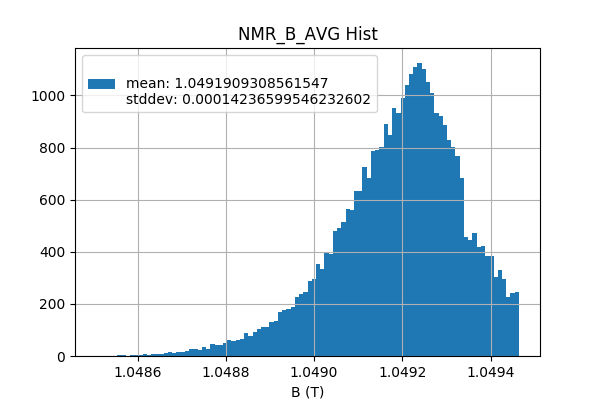

In [4]:
_ = plt.figure()
df.NMR_B_AVG.hist(bins=100,label=f"\nmean: {df.NMR_B_AVG.mean()}\nstddev: {df.NMR_B_AVG.std()}")

plt.title("NMR_B_AVG Hist")
plt.xlabel("B (T)")
plt.legend();

### Example 2: 3D scatter plot with gradient cut
- Uses pandas filtering and imported hallprobecalib plotting function "Scatter3d"

<IPython.core.display.Javascript object>


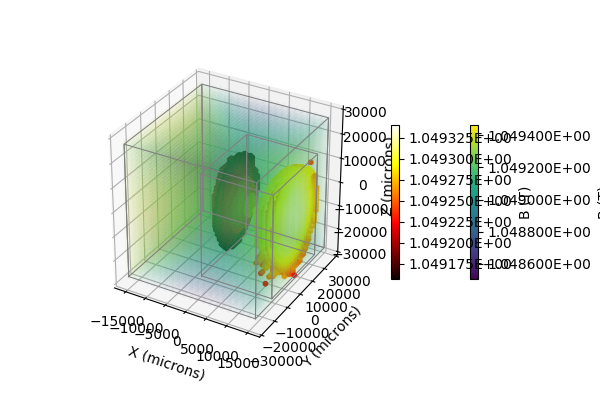

In [38]:
fig,ax = Scatter3d(df.X,df.Y,df.Z,df.NMR_B_AVG,colorsMap='viridis',alpha=0.025,psize=10)
g_cut = df.GRAD_B_MAG < df.GRAD_B_MAG.quantile(0.1)
fig,ax = Scatter3d(df[g_cut].X,df[g_cut].Y,df[g_cut].Z,df[g_cut].NMR_B_AVG,
                   colorsMap='hot',alpha=1.,psize=10,fig=fig,ax=ax)

<IPython.core.display.Javascript object>


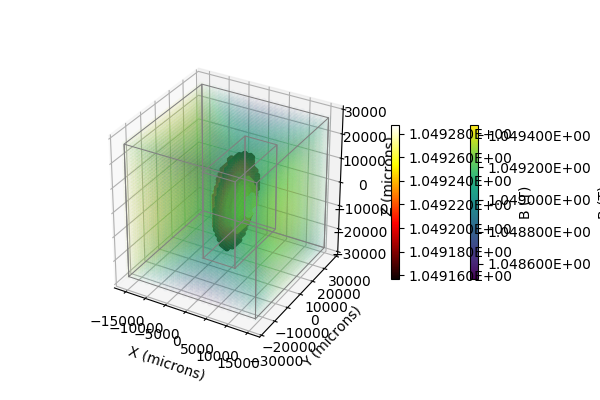

In [39]:
x0 = df.X < 7500
fig,ax = Scatter3d(df.X,df.Y,df.Z,df.NMR_B_AVG,colorsMap='viridis',alpha=0.025,psize=10)
fig,ax = Scatter3d(df[g_cut&x0].X,df[g_cut&x0].Y,df[g_cut&x0].Z,df[g_cut&x0].NMR_B_AVG,
                   colorsMap='hot',alpha=1.,psize=10,fig=fig,ax=ax)

<IPython.core.display.Javascript object>


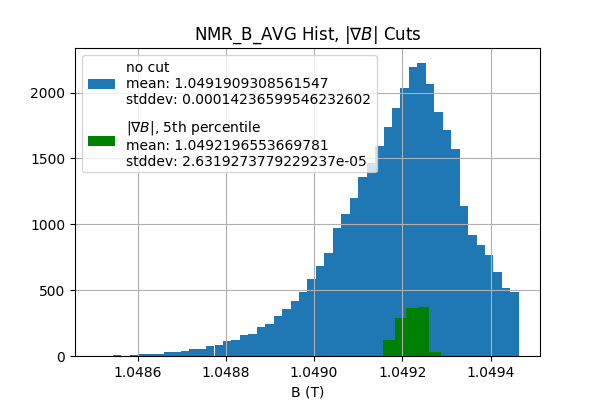

In [40]:
_ = plt.figure()
df.NMR_B_AVG.hist(bins=50, label=r"no cut"+f"\nmean: {df.NMR_B_AVG.mean()}\nstddev: {df.NMR_B_AVG.std()}")
df[g_cut&x0].NMR_B_AVG.hist(bins=5, color='green',label=r"$|\nabla B|$, 5th percentile"+f"\nmean: {df[g_cut&x0].NMR_B_AVG.mean()}\nstddev: {df[g_cut&x0].NMR_B_AVG.std()}")

plt.title(r"NMR_B_AVG Hist, $|\nabla B|$ Cuts")
plt.xlabel("B (T)")
plt.legend();

<IPython.core.display.Javascript object>


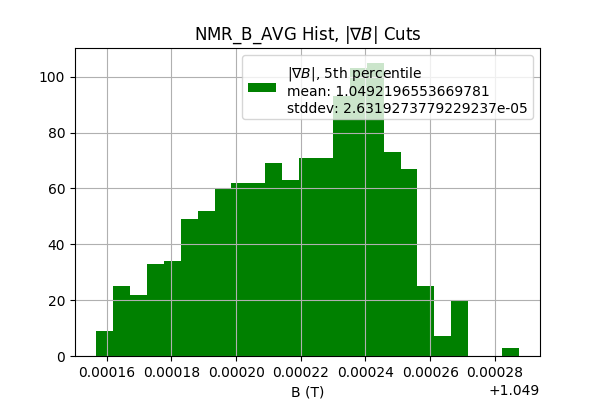

In [41]:
_ = plt.figure()
df[g_cut&x0].NMR_B_AVG.hist(bins=25, color='green', label=r"$|\nabla B|$, 5th percentile"+f"\nmean: {df[g_cut&x0].NMR_B_AVG.mean()}\nstddev: {df[g_cut&x0].NMR_B_AVG.std()}")

plt.title(r"NMR_B_AVG Hist, $|\nabla B|$ Cuts")
plt.xlabel("B (T)")
plt.legend();

In [42]:
#plt.close("all")

In [44]:
len(df[g_cut&x0])

1178

In [45]:
df.NMR_B_AVG.max()-df.NMR_B_AVG.min()

0.0009582432599997137

In [46]:
df[g_cut&x0].NMR_B_AVG.max()-df[g_cut&x0].NMR_B_AVG.min()

0.00013070090000000256

min_b_range yields: 3.4769e-6 T (5 percentile gradient)
                    9.8187e-6 T (10 percentile gradient)

# **Takeaways**
- Serializing data greatly improves speed of data loading and decreases file size
- Will need to make concrete estimates of expected data quantities.

**Q: Is the current method good enough?**

A: Probably. My estimate for 1,000,000 measurements: 6 GB raw (~4 min to load, pickling), 325.8 MB pickled (~1.5 s to load).

In [47]:
df.columns

Index(['PS_DMM', 'X_ZAB', 'Y_ZAB', 'Z_ZAB', 'X', 'Y', 'Z', 'PAT_X', 'PAT_Y',
       'PAT_Z', 'BX_CAL_1', 'BY_CAL_1', 'BZ_CAL_1', 'BX_CAL_2', 'BY_CAL_2',
       'BZ_CAL_2', 'BX_RAW_1', 'BY_RAW_1', 'BZ_RAW_1', 'BX_RAW_2', 'BY_RAW_2',
       'BZ_RAW_2', 'B_MAG_CAL_1', 'B_MAG_CAL_2', 'NMR_B_AVG', 'FFT_MAX',
       'TEMP_1', 'TEMP_2', 'GRAD_B_X', 'GRAD_B_Y', 'GRAD_B_Z', 'GRAD_B_MAG'],
      dtype='object')

In [48]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [54]:
trace1 = go.Scatter3d(
    x=df.X,
    y=df.Y,
    z=df.Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df.NMR_B_AVG,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.2
    )
)

trace2 = go.Scatter3d(
    x=df[g_cut&x0].X,
    y=df[g_cut&x0].Y,
    z=df[g_cut&x0].Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df[g_cut&x0].NMR_B_AVG,                # set color to an array/list of desired values
        colorscale='Hot',   # choose a colorscale
        opacity=1.
    )
)

data = [trace1,trace2]

layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig2 = go.Figure(data=data, layout=layout)

In [55]:
#iplot(fig2, filename='3d-scatter-colorscale-NMR-B')
iplot(fig2)

In [56]:
fig3 = go.Figure(data=[trace2], layout=layout)
iplot(fig3)

In [64]:
x_cut = df.X == 0.
x = df[x_cut].Y.unique()
y = df[x_cut].Z.unique()
z = np.array(df[x_cut].GRAD_B_MAG.abs())

g_max = df[x_cut].GRAD_B_MAG.quantile(0.05)

z = [i if i<=g_max else g_max for i in z]

In [65]:
xx,yy= np.meshgrid(x,y)
zz = np.reshape(z,(len(x),len(y)))

In [66]:
data = [go.Surface(x=xx,y=yy,z=zz, colorscale="Viridis")]
layout = go.Layout(
    title='Grad B Magnitude',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
#fig = dict(data=data, layout=layout) 
iplot(data, filename='gradient_test.html')

In [67]:
g_cut_slice = df[x_cut].GRAD_B_MAG < df[x_cut].GRAD_B_MAG.quantile(0.05)


In [68]:
trace = go.Scatter3d(
    x=df[g_cut_slice&x_cut].X,
    y=df[g_cut_slice&x_cut].Y,
    z=df[g_cut_slice&x_cut].Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df[g_cut_slice&x_cut].NMR_B_AVG,                # set color to an array/list of desired values
        colorscale='Hot',   # choose a colorscale
        opacity=1.
    )
)

data = [trace]

layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

In [70]:
iplot(fig)

In [71]:
df[g_cut_slice&x_cut].NMR_B_AVG.max()-df[g_cut_slice&x_cut].NMR_B_AVG.min()

1.771861999966262e-05

In [72]:
df[x_cut].NMR_B_AVG.max()-df[x_cut].NMR_B_AVG.min()

0.0006619473599998038